In [1]:
# !pip install pyunpack
# !pip install patool

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# from pyunpack import Archive
# Archive('/content/drive/My Drive/Data_Set_2(Black_and_white_images).rar').extractall('/content/drive/My Drive/Data_Set_2(Black_and_white_images)')

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import pandas as pd
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from io import StringIO
from sklearn.metrics import accuracy_score, f1_score, precision_score
import pickle

In [5]:
class DatasetClass(Dataset):
    
    def __init__(self, folder, filename, label_dict):
        
        self.data = []
        self.filename = filename
        tar = tarfile.open(folder + '/' + filename)
        for file in tar.getmembers():
            f = tar.extractfile(file)
            if f != None:
                content = pd.read_csv(StringIO(f.read().decode()), sep=' ', header=None).values.ravel()
                self.data.append(content)
            
        self.y = torch.tensor(label_dict[self.filename[:-7]], dtype=torch.long)
    
    def __getitem__(self, idx):     
        
        return torch.tensor(self.data[idx], dtype=torch.float), self.y
      
    def __len__(self):
        
        return len(self.data)

In [6]:
def train_test_loader(directory, label_dict, train_fraction=0.8, num_workers=2):

    all_files = list(filter(lambda x: x.endswith('.tar.gz'), os.listdir(directory)))
    files = [file for file in all_files if file[:-7] in label_dict.keys()]
    
    datasets = list(map(lambda x : DatasetClass(directory, x, label_dict), files))
    dataset = ConcatDataset(datasets)
    N = dataset.cumulative_sizes[-1]
    
    train_size = int(N*train_fraction)
    test_size = N - train_size

    train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

    trainloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=num_workers)
    testloader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=num_workers)
    
    return trainloader, testloader, train_size, test_size

In [7]:
label_dict = {
    'tallbuilding': 0,
    'mountain': 1,
    'highway': 2,
    'coast': 3, 
    'opencountry': 4}

trainloader, testloader, train_size, test_size = train_test_loader('/content/drive/My Drive/Data_Set_1(Colored_Images)', label_dict, train_fraction=0.8, num_workers=0)

In [8]:
class AutoEncoder(nn.Module):
    
    def __init__(self, n_features, h_layer_sizes):
        super(AutoEncoder, self).__init__()
        
        self.fc1 = nn.Linear(n_features, h_layer_sizes[0])
        self.fc2 = nn.Linear(h_layer_sizes[0], h_layer_sizes[1])
        self.fc3 = nn.Linear(h_layer_sizes[1], h_layer_sizes[2])
        self.out = nn.Linear(h_layer_sizes[2], n_features)
        
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x)) # Hidden Layer 1 (Tanh)
        x = self.fc2(x)    # Hidden Layer 2 (Linear)
        x = torch.tanh(self.fc3(x)) # Hidden Layer 3 (Tanh)
        x = self.out(x) # Output Layer (Linear)
        
        return x
    
    def get_z(self, x):
        
        z = torch.tanh(self.fc1(x))
        z = self.fc2(z)
        
        return z

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
X_train = []
for X, y in trainloader:
  X_train.extend(X.numpy())
X_train = np.array(X_train)

97% Variance Explained: 228


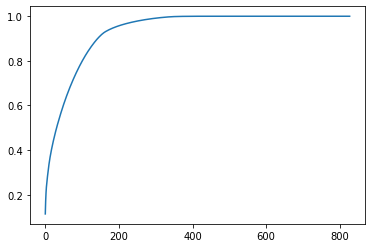

In [11]:
pca1 = PCA(n_components=X_train.shape[1])
pca1.fit(X_train)

print('97% Variance Explained:', np.where(np.cumsum(pca1.explained_variance_ratio_)>=0.97)[0][0]+1)
explained_var = np.cumsum(pca1.explained_variance_ratio_)
plt.plot(explained_var)
plt.show()

In [12]:
criterion = nn.MSELoss()

ae1 = AutoEncoder(828, [400, 200, 400])
ae1 = ae1.to(device)
optimizer1 = optim.SGD(ae1.parameters(), lr=0.0001, momentum=0.9)

Epoch 1 : Loss = 1.9403873682022095
Epoch 2 : Loss = 1.9177996868436988
Epoch 3 : Loss = 1.895418722521175
Epoch 4 : Loss = 1.8738206733356826
Epoch 5 : Loss = 1.852434567429802
Epoch 6 : Loss = 1.8307957622137936
Epoch 7 : Loss = 1.80853272839026
Epoch 8 : Loss = 1.7852746194059197
Epoch 9 : Loss = 1.7608684030446136
Epoch 10 : Loss = 1.7350585569034929
Epoch 11 : Loss = 1.7076921544291765
Epoch 12 : Loss = 1.6787846305153584
Epoch 13 : Loss = 1.6481998589905824
Epoch 14 : Loss = 1.6159914217211981
Epoch 15 : Loss = 1.5821706273339011
Epoch 16 : Loss = 1.546823943203146
Epoch 17 : Loss = 1.5100137103687639
Epoch 18 : Loss = 1.471907621080225
Epoch 19 : Loss = 1.4326800378886135
Epoch 20 : Loss = 1.3924544887109234
Epoch 21 : Loss = 1.351450622081756
Epoch 22 : Loss = 1.3099071031266991
Epoch 23 : Loss = 1.2679279256950726
Epoch 24 : Loss = 1.2258631966330786
Epoch 25 : Loss = 1.1837784024802123
Epoch 26 : Loss = 1.141958174380389
Epoch 27 : Loss = 1.1005016429857777
Epoch 28 : Loss = 

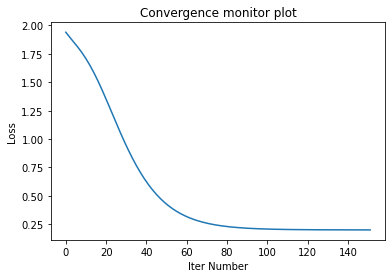

In [13]:
old_loss = np.inf

max_epoch = 500
losses = []
for epoch in range(max_epoch):

    running_loss = 0.0
    len_ = 0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        optimizer1.zero_grad()
        
        # Reconstructed Representation of X (forward)
        X_hat = ae1(X)
        
        # Calculate Loss (MSE)
        loss = criterion(X_hat, X)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer1.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)
    
    if (abs(running_loss-old_loss)/running_loss < 1e-4) and running_loss<0.201:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [14]:
test_loss = 0.0

for data in testloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      X_pred = ae1(X)
      loss = criterion(X_pred, X)

    test_loss += loss.item()*len(X)/test_size

test_loss = test_loss
print(test_loss)

0.2036638016050512


In [15]:
Z1_array = []

for data in trainloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      Z1 = ae1.get_z(X)

    if len(Z1_array) == 0:
        Z1_array = Z1.cpu().numpy()
    else:
        Z1_array = np.append(Z1_array, Z1.cpu().numpy(), axis=0)

97% Variance Explained: 76


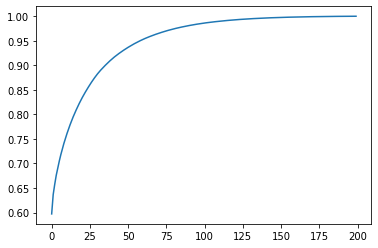

In [16]:
pca2 = PCA(n_components=Z1_array.shape[1])
pca2.fit(Z1_array)
print('97% Variance Explained:', np.where(np.cumsum(pca2.explained_variance_ratio_)>=0.97)[0][0]+1)

explained_var = np.cumsum(pca2.explained_variance_ratio_)
plt.plot(explained_var)
plt.show()

In [17]:
ae2 = AutoEncoder(200, [150, 75, 150])
optimizer2 = optim.SGD(ae2.parameters(), lr=0.0001, momentum=0.9)
ae2 = ae2.to(device)

Epoch 1 : Loss = 2.486224949359894
Epoch 2 : Loss = 2.4323756965723917
Epoch 3 : Loss = 2.373781751502644
Epoch 4 : Loss = 2.3116262500936333
Epoch 5 : Loss = 2.245121278546073
Epoch 6 : Loss = 2.1738502708348357
Epoch 7 : Loss = 2.0976461822336376
Epoch 8 : Loss = 2.016669798981059
Epoch 9 : Loss = 1.9312594614245666
Epoch 10 : Loss = 1.8419459895654162
Epoch 11 : Loss = 1.749526514248415
Epoch 12 : Loss = 1.654785167087208
Epoch 13 : Loss = 1.5587453110651532
Epoch 14 : Loss = 1.4622688022526829
Epoch 15 : Loss = 1.3663457550785756
Epoch 16 : Loss = 1.2718696783889425
Epoch 17 : Loss = 1.1796076351946048
Epoch 18 : Loss = 1.0903383628888565
Epoch 19 : Loss = 1.0045466599139297
Epoch 20 : Loss = 0.9227807318622416
Epoch 21 : Loss = 0.845357372002168
Epoch 22 : Loss = 0.7724495950070294
Epoch 23 : Loss = 0.7042089605873281
Epoch 24 : Loss = 0.6406712599776008
Epoch 25 : Loss = 0.58179073035717
Epoch 26 : Loss = 0.5274055498567493
Epoch 27 : Loss = 0.47739270058545186
Epoch 28 : Loss = 

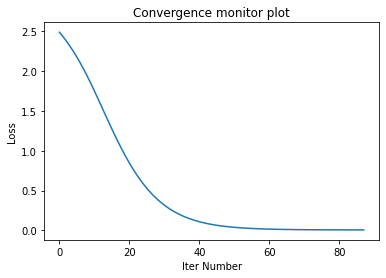

In [18]:
old_loss = np.inf
losses = []
max_epoch = 500

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            Z = ae1.get_z(X)
        
        optimizer2.zero_grad()
        
        # Reconstructed Representation of X (forward)
        Z_hat = ae2(Z)
        
        # Calculate Loss (MSE)
        loss = criterion(Z_hat, Z)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer2.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    losses.append(running_loss)
    print('Epoch', epoch+1, ': Loss =', running_loss)
    
    if abs(running_loss-old_loss)/running_loss < 0.01 and running_loss<9e-3:
        print('Converged')
        break
        
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [19]:
test_loss = 0.0

for data in testloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      Z = ae1.get_z(X)
      Z_pred = ae2(Z)
      loss = criterion(Z_pred, Z)

    test_loss += loss.item()*len(X)/test_size

test_loss = test_loss
print(test_loss)

0.006431612948125059


In [20]:
Z2_array = []

for data in trainloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      Z1 = ae1.get_z(X)
      Z2 = ae2.get_z(Z1)

    if len(Z2_array) == 0:
        Z2_array = Z2.cpu().numpy()
    else:
        Z2_array = np.append(Z2_array, Z2.cpu().numpy(), axis=0)

97% Variance Explained: 11


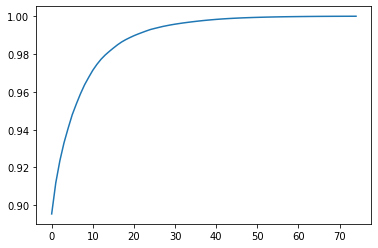

In [21]:
pca3 = PCA(n_components=Z2_array.shape[1])
pca3.fit(Z2_array)
print('97% Variance Explained:', np.where(np.cumsum(pca3.explained_variance_ratio_)>=0.97)[0][0]+1)

explained_var = np.cumsum(pca3.explained_variance_ratio_)
plt.plot(explained_var)
plt.show()

In [22]:
ae3 = AutoEncoder(75, [50, 15, 50])
optimizer3 = optim.SGD(ae3.parameters(), lr=0.0001, momentum=0.9)
ae3 = ae3.to(device)

Epoch 1 : Loss = 2.7355596314777033
Epoch 2 : Loss = 2.673307229172099
Epoch 3 : Loss = 2.609427863901311
Epoch 4 : Loss = 2.5444942658597762
Epoch 5 : Loss = 2.476547067815607
Epoch 6 : Loss = 2.404238722541115
Epoch 7 : Loss = 2.3268609155308115
Epoch 8 : Loss = 2.2442985718900506
Epoch 9 : Loss = 2.156820232217962
Epoch 10 : Loss = 2.064958323131908
Epoch 11 : Loss = 1.969396255233071
Epoch 12 : Loss = 1.8710036955096512
Epoch 13 : Loss = 1.770762828263369
Epoch 14 : Loss = 1.6697434430772609
Epoch 15 : Loss = 1.5689754296432845
Epoch 16 : Loss = 1.4694481762972746
Epoch 17 : Loss = 1.3720183670520778
Epoch 18 : Loss = 1.277424877340143
Epoch 19 : Loss = 1.1862492994828662
Epoch 20 : Loss = 1.0989422391761436
Epoch 21 : Loss = 1.0158225758509203
Epoch 22 : Loss = 0.9370876293290746
Epoch 23 : Loss = 0.862868684259328
Epoch 24 : Loss = 0.7931782589717342
Epoch 25 : Loss = 0.7279703888026152
Epoch 26 : Loss = 0.6671892987056213
Epoch 27 : Loss = 0.6106700165705246
Epoch 28 : Loss = 0.

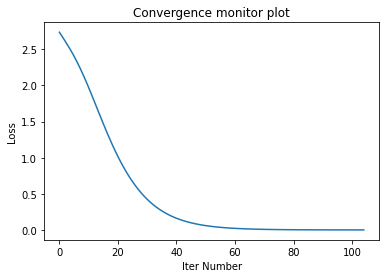

In [23]:
old_loss = np.inf

max_epoch = 500
losses = []

for epoch in range(max_epoch):

    running_loss = 0.0
    for data in trainloader:
        
        X, _ = data[0].to(device), data[1].to(device)
        
        with torch.no_grad():
            Z1 = ae1.get_z(X)
            Z = ae2.get_z(Z1)
        
        optimizer3.zero_grad()
        
        # Reconstructed Representation of Z (forward)
        Z_hat = ae3(Z)
        
        # Calculate Loss (MSE)
        loss = criterion(Z_hat, Z)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer3.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)

    if abs(running_loss-old_loss)/running_loss < 0.05 and running_loss<1e-3:
        print('Converged')
        break
        
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [24]:
test_loss = 0.0

for data in testloader:
        
    X, _ = data[0].to(device), data[1].to(device)
    with torch.no_grad():
      Z1 = ae1.get_z(X)
      Z = ae2.get_z(Z1)
      Z_pred = ae3(Z)
      loss = criterion(Z_pred, Z)

    test_loss += loss.item()*len(X)/test_size

test_loss = test_loss
print(test_loss)

0.0005464660141363063


In [25]:
class FinalNet(nn.Module):
    
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(FinalNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.out = nn.Linear(hidden_sizes[3], num_classes)
    
    def forward(self, x):
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.out(x)
        
        return x
    
    def predict(self, X):
        
        with torch.no_grad():
            y_score = self.forward(X)
            y_pred = torch.argmax(y_score, axis=1)
            
        return y_pred
            
    
classifier = FinalNet(828, [400, 150, 50, 15], 5)

In [26]:
ae1_params = list(ae1.parameters())
ae2_params = list(ae2.parameters())
ae3_params = list(ae3.parameters())
pickle.dump((ae1_params, ae2_params, ae3_params), open('/content/drive/My Drive/Ass1Q2_init.sav', 'wb'))

# (ae1_params, ae2_params, ae3_params) = pickle.load(open('/content/drive/My Drive/Ass1Q2_init.sav', 'rb'))

with torch.no_grad():
    
    classifier.fc1.weight.data = nn.Parameter(ae1_params[0])
    classifier.fc1.bias.data = nn.Parameter(ae1_params[1])
    
    classifier.fc2.weight = nn.Parameter(torch.matmul(ae2_params[0], ae1_params[2]))
    classifier.fc2.bias = nn.Parameter(torch.matmul(ae2_params[0], ae1_params[3]) + ae2_params[1])
    
    classifier.fc3.weight = nn.Parameter(torch.matmul(ae3_params[0], ae2_params[2]))
    classifier.fc3.bias = nn.Parameter(torch.matmul(ae3_params[0], ae2_params[3]) + ae3_params[1])
    
    classifier.fc4.weight = nn.Parameter(ae3_params[2])
    classifier.fc4.bias = nn.Parameter(ae3_params[3])

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
classifier = classifier.to(device)

Epoch 1 : Loss = 1.6091626394878733
Epoch 2 : Loss = 1.6014823019504556
Epoch 3 : Loss = 1.6001403602686795
Epoch 4 : Loss = 1.6000839146700767
Epoch 5 : Loss = 1.5998983437364753
Epoch 6 : Loss = 1.6006035262888128
Epoch 7 : Loss = 1.600783589211377
Epoch 8 : Loss = 1.599953304637562
Epoch 9 : Loss = 1.600238667293028
Epoch 10 : Loss = 1.6000705632296475
Epoch 11 : Loss = 1.6002734059637238
Epoch 12 : Loss = 1.6001130207018421
Epoch 13 : Loss = 1.6001790301366283
Epoch 14 : Loss = 1.600510041822087
Epoch 15 : Loss = 1.6001043428074229
Epoch 16 : Loss = 1.600325454365123
Epoch 17 : Loss = 1.5999810587276113
Epoch 18 : Loss = 1.6009076291864568
Epoch 19 : Loss = 1.6001184555617245
Epoch 20 : Loss = 1.6000924110412595
Epoch 21 : Loss = 1.6006361625411294
Epoch 22 : Loss = 1.6001604849641975
Epoch 23 : Loss = 1.5997536209496586
Epoch 24 : Loss = 1.600358228791844
Epoch 25 : Loss = 1.6003575026988985
Epoch 26 : Loss = 1.6000937629829755
Epoch 27 : Loss = 1.6002937853336334
Epoch 28 : Loss 

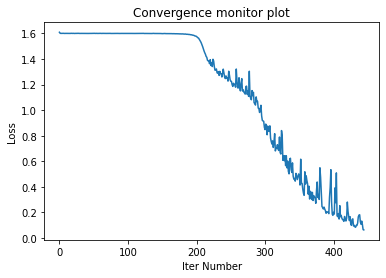

In [28]:
old_loss = np.inf

max_epoch = 500
losses = []
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = classifier(X)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)
    if abs(running_loss-old_loss)/running_loss < 0.1 and running_loss<0.075:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')
plt.plot(losses)
plt.ylabel('Loss')
plt.xlabel('Iter Number')
plt.title('Convergence monitor plot')
plt.show()

In [29]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.detach().cpu().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Train Loss =', train_loss.item())
print(pd.DataFrame(confusion_matrix(y_train, y_train_pred)))

acc = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')

print('Train Accuracy =', acc, 'Train Precision =', prec, 'Train F1 =', f1)

Train Loss = 0.05523950979113579
     0    1    2    3    4
0  282    0    0    0    0
1    0  294    1    0    1
2    1    0  210    0    0
3    0    0    0  280    7
4    0    0    0    4  328
Train Accuracy = 0.9900568181818182 Train Precision = 0.9907666127501475 Train F1 = 0.9905744802603339


In [30]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        test_loss += criterion(y_hat, y)*len(X)/test_size
        
        y_test.extend(list(y.detach().cpu().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Test Loss =', test_loss.item())
pd.DataFrame(confusion_matrix(y_test, y_test_pred))

Test Loss = 1.577786922454834


,0,1,2,3,4
0,45,16,8,3,2
1,11,45,5,6,11
2,1,5,28,14,1
3,1,3,14,41,14
4,1,7,2,9,59


In [31]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.6193181818181818 Test Precision = 0.6171699905793562 Test F1 = 0.6132409102598597


In [32]:
torch.save(classifier, '/content/drive/My Drive/A2Q2_model.pt')